In [1]:
import taichi as ti
from setup.voxel_setup import setup_voxel_scene
from simulation.simulator import *
from common.plot import Plotter
from common.octree import Octree

# debug=True to check boundary access
ti.init(arch=ti.gpu)

import numpy as np
import matplotlib
from scipy import ndimage

%load_ext autoreload
%autoreload 2

matplotlib.use('Qt5Agg')
%matplotlib widget

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] Starting on arch=cuda


## 1. Load voxel model

In [2]:
NUM_X, NUM_Y, NUM_Z = 128, 128, 128
scene, floor_height = setup_voxel_scene(NUM_X, NUM_Y, NUM_Z)

Loaded Voxel shape: (128, 128, 128)  from: ./assets/bun_zipper_res4.ply
Number of filled voxels: 13849
Loaded Voxel shape: (128, 128, 128)  from: ./assets/wine_glass.obj
Number of filled voxels: 9035
Floor Ratio: -0.3125 , Floor Height: 44


In [3]:
# scene.finish()

## 2. Light simulation

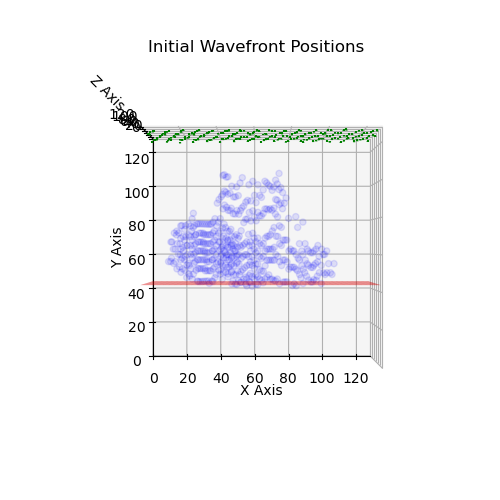

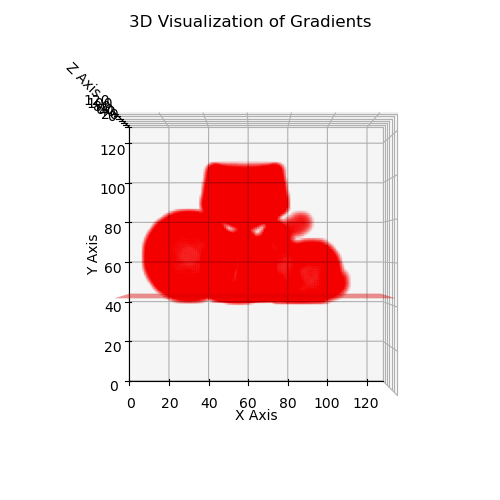

In [4]:
scene_ior = scene.get_ior()
assert isinstance(scene_ior, np.ndarray) and scene_ior.shape == (NUM_X, NUM_Y, NUM_Z), "The scene IOR should be a NumPy array of shape (NUM_X, NUM_Y, NUM_Z)"

sampler_multiplier = 3
pos_perturbation_scale = 0.45

initial_wavefront_pos, initial_wavefront_dir = generate_initial_wavefront(sampler_multiplier, pos_perturbation_scale, NUM_X, NUM_Y, NUM_Z)

smoothed_ior = ndimage.gaussian_filter(scene_ior, sigma=3.0, radius=1)
scene.set_ior(smoothed_ior)

ior_gradients = compute_ior_gradient(scene.get_ior())
scene.set_gradient(ior_gradients)

atten_grid = scene.get_attenuation()

plotter = Plotter(sampler_multiplier, floor_height, smoothed_ior)
plotter.plot_wavefront_position(initial_wavefront_pos, initial_wavefront_dir, title="Initial Wavefront Positions")
plotter.plot_gradient(scene.get_gradient(), threshold=0.01, alpha=0.01)

In [5]:
initial_wavefront_pos.shape[0]

442368

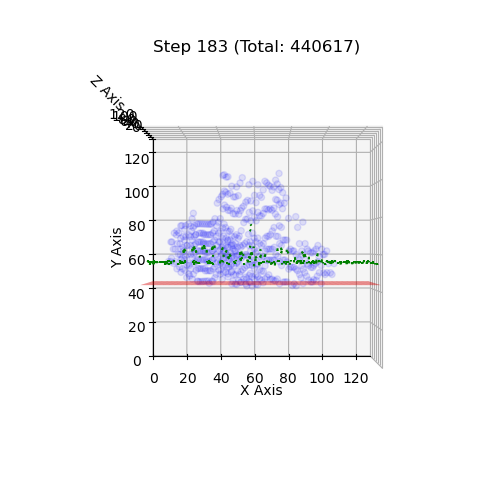

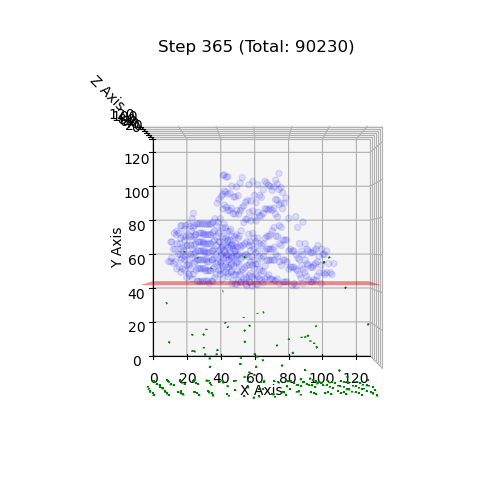

In [6]:
test_delta_t = 0.3 * (NUM_Y / 100)
test_num_steps = int(1.1 * (NUM_Y / test_delta_t))
irradiance_grid = simulate_wavefront_propagation(scene_ior, ior_gradients, atten_grid,
                                                initial_wavefront_pos, initial_wavefront_dir,
                                                device, plotter, test_num_steps, test_delta_t)

## 3. Visualise irradiance

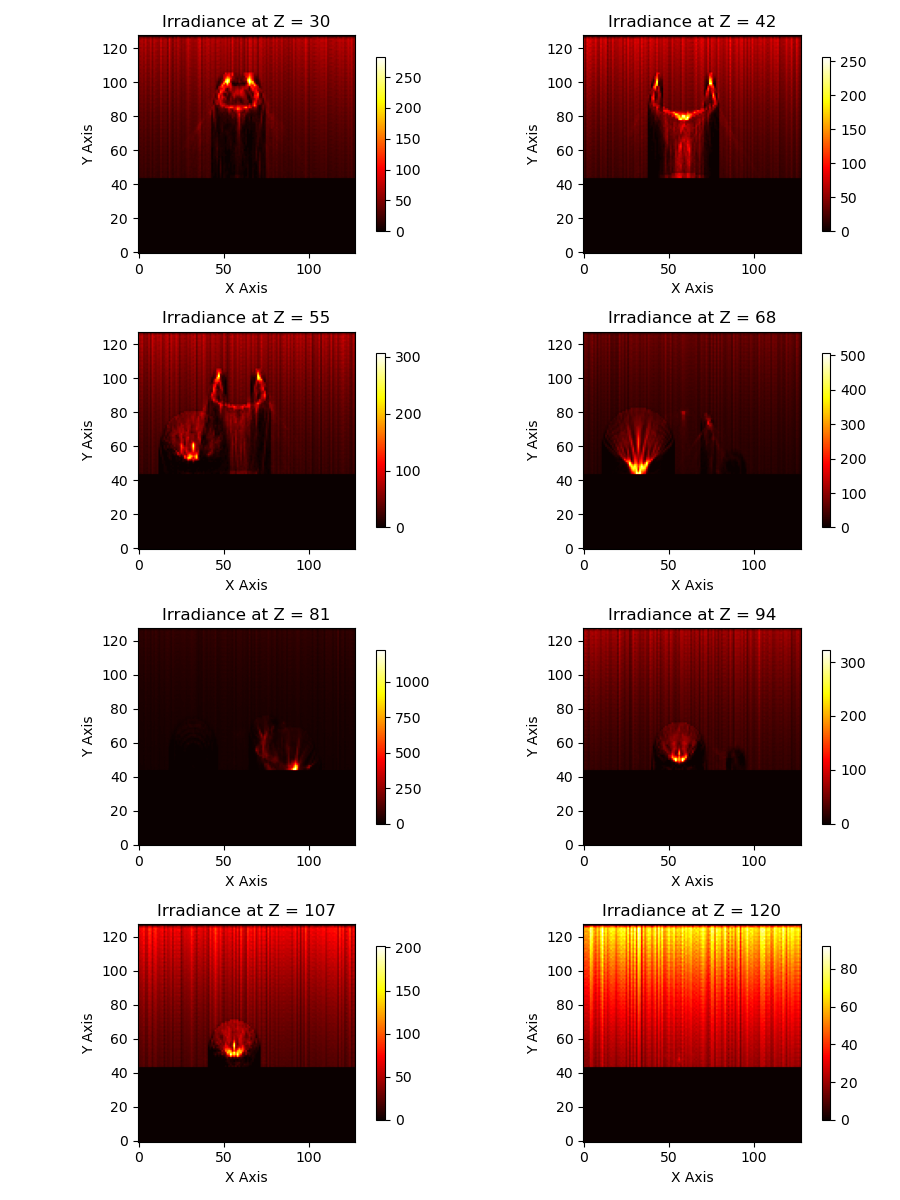

In [7]:
# plotter.plot_irradiance_grid(irradiance_grid, threshold=5*sampler_multiplier**3)
above_floor_irradiance_grid = remove_under_floor(irradiance_grid, floor_height=floor_height)
plotter.plot_irradiance_slices(above_floor_irradiance_grid, threshold=3, num_slices=8, z_start=30, z_end=120)

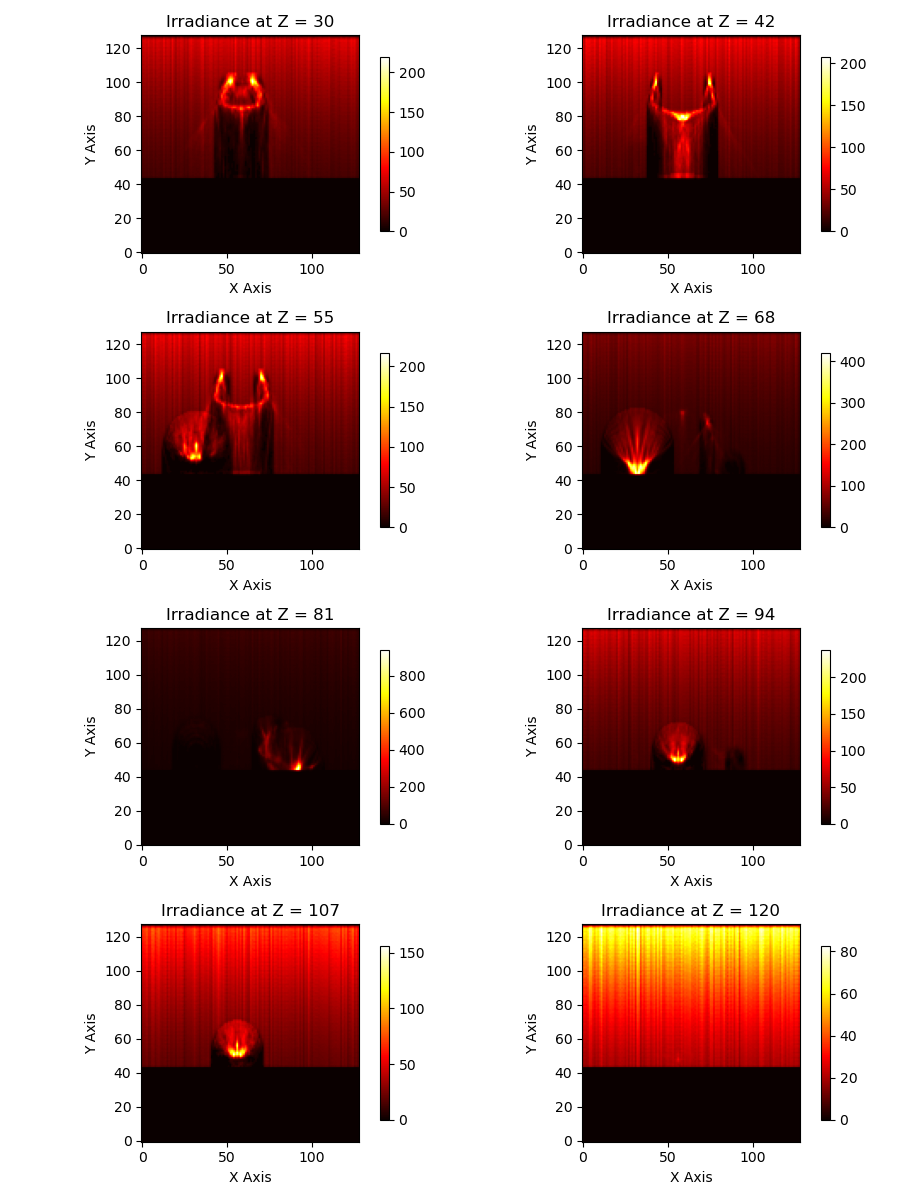

In [8]:
# Apply Gaussian filter to smooth the radiometric grid
filtered_above_floor_irradiance_grid = above_floor_irradiance_grid.copy()
filtered_above_floor_irradiance_grid = ndimage.gaussian_filter(filtered_above_floor_irradiance_grid, sigma=0.5) 
plotter.plot_irradiance_slices(filtered_above_floor_irradiance_grid, threshold=3, num_slices=8, z_start=30, z_end=120)

## 6. Neural network irradiance （MLP）

In [ ]:
# SEED = 42
# import torch.nn as nn
# class IrradianceNet(nn.Module):
#     def __init__(self):
#         super(IrradianceNet, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(3, 512),
#             nn.ReLU(),
#             nn.Linear(512, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 1)
#         )
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)

#     def forward(self, x):
#         return self.model(x).squeeze()

# def prepare_data(irradiance: torch.Tensor, train_ratio=0.90) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
#     x = np.arange(irradiance.shape[0])
#     y = np.arange(irradiance.shape[1]) 
#     z = np.arange(irradiance.shape[2])
#     X, Y, Z = np.meshgrid(x, y, z)
#     inputs = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)
#     targets = irradiance.flatten()

#     inputs = torch.from_numpy(inputs).float().to(device)
#     targets = targets.clone().detach().to(device)

#     # Random shuffle
#     # torch.manual_seed(SEED)
#     indices = torch.randperm(len(inputs))
#     inputs = inputs[indices]
#     targets = targets[indices]

#     # Split into training and validation sets
#     train_size = int(train_ratio * len(inputs))
#     train_inputs, val_inputs = inputs[:train_size], inputs[train_size:]
#     train_targets, val_targets = targets[:train_size], targets[train_size:]

#     return train_inputs, val_inputs, train_targets, val_targets

# def train_model(model: IrradianceNet, train_inputs: torch.Tensor, val_inputs: torch.Tensor, train_targets: torch.Tensor, val_targets: torch.Tensor, 
#                 num_epochs=320, batch_size=1024, patience=60):
#     torch.cuda.empty_cache()
    
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

#     best_val_loss = float('inf')
#     epochs_no_improve = 0
#     best_model = None

#     for epoch in range(num_epochs):
#         model.train()
#         for i in range(0, len(train_inputs), batch_size):
#             batch_inputs = train_inputs[i:i+batch_size]
#             batch_targets = train_targets[i:i+batch_size]
            
#             outputs = model(batch_inputs)
#             loss = criterion(outputs, batch_targets)
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
        
#         model.eval()
#         with torch.no_grad():
#             val_outputs = model(val_inputs)
#             val_loss = criterion(val_outputs, val_targets)
        
#         if val_loss < best_val_loss * 0.95: # at least 5% improvement
#             best_val_loss = val_loss
#             epochs_no_improve = 0
#             best_model = model.state_dict()
#             print(f"Current best model is at epoch {epoch + 1} and val loss: {val_loss.item():.4f}")
#         else:
#             epochs_no_improve += 1
        
#         if epochs_no_improve == patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break
        
#         if (epoch + 1) % 40 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

#     assert best_model is not None
#     model.load_state_dict(best_model)
#     torch.cuda.empty_cache()
#     return model

# def generate_irradiance_field_3d(model: IrradianceNet, size=100) -> torch.Tensor:
#     x = np.arange(size)
#     y = np.arange(size)
#     z = np.arange(size)
#     X, Y, Z = np.meshgrid(x, y, z)
#     coords = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)    
#     with torch.no_grad():
#         inputs = torch.tensor(coords, dtype=torch.float32, device=device)
#         predictions = model(inputs)
    
#     return predictions.reshape(size, size, size)

# # Prepare the data and train the MLP model
# train_inputs, val_inputs, train_targets, val_targets = prepare_data(irradiance_grid)
# model = IrradianceNet().to(device)  
# model = train_model(model, train_inputs, val_inputs, train_targets, val_targets)

# # Visualize the predicted irradiance field
# predicted_irradiance = generate_irradiance_field_3d(model)
# show_radiometric_grid_3d(predicted_irradiance, threshold=0.2, only_above_floor=True)

## 7. Octree

In [ ]:
octree = Octree(threshold=2 * (sampler_multiplier**3))
octree.construct(filtered_above_floor_irradiance_grid)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {filtered_above_floor_irradiance_grid.nbytes} bytes")
octree.visualize(plotter)

In [ ]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

## Temp Tests

In [ ]:
# x = ti.field(float, shape=(3, 3))
# a = np.arange(9).reshape(3, 3).astype(np.int32)
# x.from_numpy(a)
# print(x)
# type(x)
# arr = x.to_numpy()
# print(arr)
# type(arr)
# field = ti.Vector.field(3, int, shape=(256, 512))
# field.shape  # (256, 512)
# field.n      # 3

# array = field.to_numpy()
# array.shape  # (256, 512, 3)
# print(type(array))

# field.from_numpy(array)  # the input array must in the shape (256, 512, 3)
# print(type(field))

In [ ]:
@ti.data_oriented
class TiArray:
    def __init__(self, n):
        self.x = ti.field(dtype=ti.i32, shape=n)

    @ti.kernel
    def inc(self):
          
        for i in self.x:
            self.x[i] += 1

a = TiArray(32)
a.inc()
print(a.x.to_numpy())
print(a.x.dtype)

## *. Render